# 6.4 例題: ベイズ多腕バンディット

In [1]:
using Distributions
using Plots
using Printf

In [2]:
struct Bandits
    p::Vector{Float64}
end

function pull(b::Bandits, i::T) where {T <: Integer}
    rand() < b.p[i]
end

length(b::Bandits) = Base.length(b.p)

length (generic function with 1 method)

In [3]:
x = Bandits([0.4, 0.2])

Bandits([0.4, 0.2])

In [4]:
pull(x, 2)

false

In [5]:
length(x)

2

In [6]:
mutable struct BayesianStrategy
    bandits::Bandits
    wins::Vector{Int64}
    trials::Vector{Int64}
    N::Int64
    choices::Vector{Float64}
    bb_score::Vector{Bool}
end

function BayesianStrategy(b::Bandits)
    n_bandits = length(b)
    BayesianStrategy(b, zeros(n_bandits), zeros(n_bandits), 0, [], [])
end

function sample_bandits(strategy::BayesianStrategy, n::Int64)
    bb_score = zeros(n)
    choices = zeros(n)
    for k in 1:n
        # バンディットの事前分布からサンプリングし、最も値の大きいサンプルを選択
        choice = argmax(rand.(Beta.(1 .+ strategy.wins, 1 .+ strategy.trials - strategy.wins)))
        
        # 選択されたバンディットからサンプリング
        result = pull(strategy.bandits, choice)
        
        strategy.wins[choice] += result
        strategy.trials[choice] += 1
        bb_score[k] = result
        strategy.N += 1
        choices[k] = choice
    end
    
    strategy.bb_score = [strategy.bb_score..., bb_score...]
    strategy.choices = [strategy.choices..., choices...]
    strategy
end

sample_bandits (generic function with 1 method)

In [7]:
y = BayesianStrategy(x)

BayesianStrategy(Bandits([0.4, 0.2]), [0, 0], [0, 0], 0, Float64[], Bool[])

In [8]:
sample_bandits(y, 3)

BayesianStrategy(Bandits([0.4, 0.2]), [0, 1], [0, 3], 3, [2.0, 2.0, 2.0], Bool[false, false, true])

In [9]:
function plot_priors(b::BayesianStrategy, prob::Vector{Float64})
    x = range(0.001, stop=0.999, length=200)
    wins = b.wins
    trials = b.trials
    
    betas = Beta.(1 .+ wins, 1 .+ trials .- wins)
    
    plt = plot()
    for i in 1:Base.length(prob)
        y = pdf.(betas[i], x)
        plot!(x, y, fillrange = 0, fillalpha = 0.3, label = "",
            title = @sprintf("Posterior after %d pulls", b.N), titlefontsize=10)
    end
    plt
end

plot_priors (generic function with 1 method)

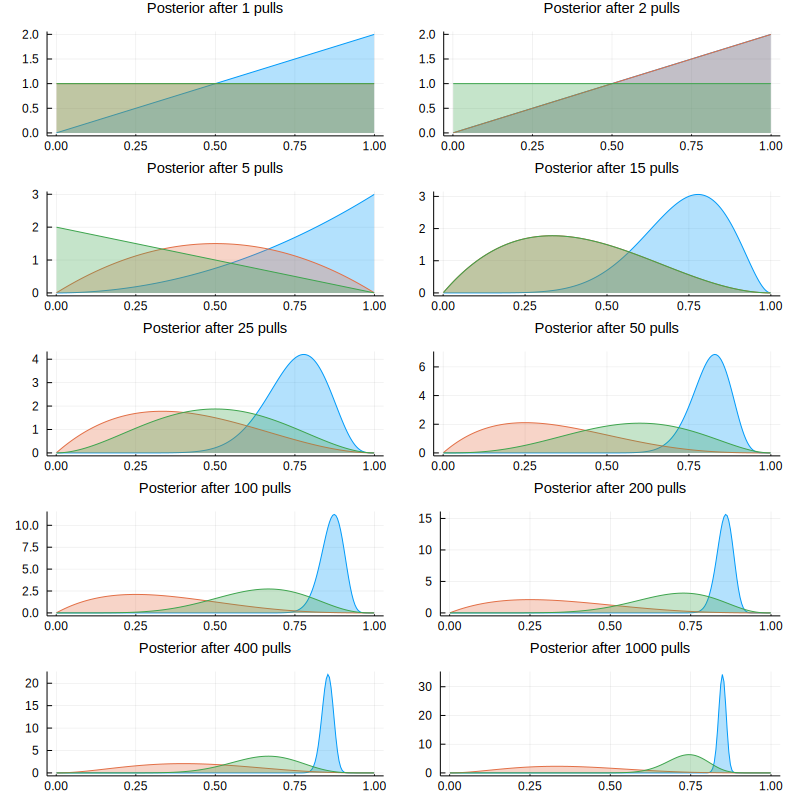

In [10]:
hidden_prob = [0.85, 0.60, 0.75]
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 600]
plts = []

for s in draw_samples
    sample_bandits(bayesian_strat, s)
    push!(plts, plot_priors(bayesian_strat, hidden_prob))
end

Plots.plot(plts..., layout = (5, 2), size = [800, 800])

## バンディット戦略を定義

In [11]:
mutable struct GeneralBanditStrat
    bandits::Bandits
    wins::Vector{Int64}
    trials::Vector{Int64}
    N::Int64
    choices::Vector{Float64}
    bb_score::Vector{Bool}
    choice_function::Function
end

function GeneralBanditStrat(b::Bandits, choice_function::Function)
    n_bandits = length(b)
    GeneralBanditStrat(b, zeros(n_bandits), zeros(n_bandits), 0, [], [], choice_function)
end

function sample_bandits(strategy::GeneralBanditStrat, n::Int64)
    bb_score = zeros(n)
    choices = zeros(n)
    for k in 1:n
        # バンディットの事前分布からサンプリングし、最も値の大きいサンプルを選択
        choice = strategy.choice_function(strategy)
        
        # 選択されたバンディットからサンプリング
        result = pull(strategy.bandits, choice)
        
        strategy.wins[choice] += result
        strategy.trials[choice] += 1
        bb_score[k] = result
        strategy.N += 1
        choices[k] = choice
    end
    
    strategy.bb_score = [strategy.bb_score..., bb_score...]
    strategy.choices = [strategy.choices..., choices...]
    strategy
end

sample_bandits (generic function with 2 methods)

In [20]:
function bayesian_bandit_choice(strategy::GeneralBanditStrat)
    argmax(rand.(Beta.(1 .+ strategy.wins, 1 .+ strategy.trials - strategy.wins))) 
end

function max_mean(strategy::GeneralBanditStrat)
    argmax(strategy.wins ./ (strategy.trials .+ 1))
end

function lower_credible_choice(strategy::GeneralBanditStrat)
    lb(a, b) = a / (a + b) - 1.65 * sqrt(a * b / ((a + b)^2 * (a + b + 1)))
    argmax(lb.(1 .+ strategy.wins, 1 .+ strategy.trials - strategy.wins))
end

function upper_credible_choice(strategy::GeneralBanditStrat)
    lb(a, b) = a / (a + b) + 1.65 * sqrt(a * b / ((a + b)^2 * (a + b + 1)))
    argmax(lb.(1 .+ strategy.wins, 1 .+ strategy.trials - strategy.wins))
end

function ucb_bayes(strategy::GeneralBanditStrat)
    alpha = 1 - 1 / (strategy.N + 1)
    argmax(quantile.(Beta.(1 .+ strategy.wins, 1 .+ strategy.trials - strategy.wins)))
end

function random_choice(strategy::GeneralBanditStrat)
    rand(1:Base.length(strategy.wins))
end

random_choice (generic function with 1 method)

In [14]:
hiddeen_prob = [0.15, 0.2, 0.1, 0.05]
bandits = Bandits(hidden_prob)

Bandits([0.85, 0.6, 0.75])

In [22]:
function regret(probabilities, choices)
    w_opt = max(probabilities)
    cumsum(w_opt .- probabilities[choices])
end

strats = [upper_credible_choice, bayesian_bandit_choice, ucb_bayes, max_mean, random_choice]
algos = [GeneralBanditStrat(bandits, s) for s in strats]

5-element Array{GeneralBanditStrat,1}:
 GeneralBanditStrat(Bandits([0.85, 0.6, 0.75]), [0, 0, 0], [0, 0, 0], 0, Float64[], Bool[], upper_credible_choice) 
 GeneralBanditStrat(Bandits([0.85, 0.6, 0.75]), [0, 0, 0], [0, 0, 0], 0, Float64[], Bool[], bayesian_bandit_choice)
 GeneralBanditStrat(Bandits([0.85, 0.6, 0.75]), [0, 0, 0], [0, 0, 0], 0, Float64[], Bool[], ucb_bayes)             
 GeneralBanditStrat(Bandits([0.85, 0.6, 0.75]), [0, 0, 0], [0, 0, 0], 0, Float64[], Bool[], max_mean)              
 GeneralBanditStrat(Bandits([0.85, 0.6, 0.75]), [0, 0, 0], [0, 0, 0], 0, Float64[], Bool[], random_choice)         